https://www.kaggle.com/c/tutors-expected-math-exam-results/data  <br>
nikname kaggle: Alex Green

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0


In [4]:
train.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,45.878000,1.986800,1699.105000,1.719500,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400,64.340800
std,2886.89568,8.043929,1.772213,524.886654,0.792264,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933,13.536823
min,0.00000,23.000000,0.000000,200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
25%,2499.75000,40.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000
50%,4999.50000,46.000000,2.000000,1500.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000
75%,7499.25000,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000
max,9999.00000,68.000000,10.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [5]:
# переведем признак "qualification" в бинарный

qualification = train['qualification']
encod_qualific = LabelBinarizer()
qual_bins = encod_qualific.fit_transform(qualification)
tmp = pd.DataFrame(qual_bins)
tmp_col = ['qualification_'+str(i) for i in tmp.columns]
tmp.columns = tmp_col
train = pd.concat([train, tmp], axis=1)
train.drop(columns=['qualification'], inplace=True, axis=1)

tmp_test = pd.DataFrame(encod_qualific.transform(test['qualification']), columns=tmp_col)
test = pd.concat([test, tmp_test], axis=1)
test.drop(columns=['qualification'], inplace=True, axis=1)

In [6]:
# # переведем признак "years_of_experience" в бинарный

# qualification = train['years_of_experience']
# encod_years = LabelBinarizer()
# qual_bins = encod_years.fit_transform(qualification)
# tmp = pd.DataFrame(qual_bins)
# tmp_col = ['years_of_experience_'+str(i) for i in tmp.columns]
# tmp.columns = tmp_col
# train = pd.concat([train, tmp], axis=1)
# train.drop(columns=['years_of_experience'], inplace=True, axis=1)

# tmp_test = pd.DataFrame(encod_years.transform(test['years_of_experience']), columns=tmp_col)
# test = pd.concat([test, tmp_test], axis=1)
# test.drop(columns=['years_of_experience'], inplace=True, axis=1)

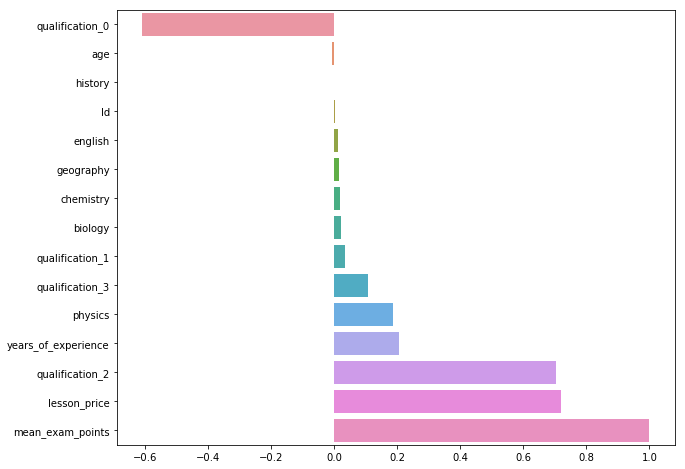

In [7]:
# Корреляция с лелевым признаком
plt.figure(figsize=(10, 8))

sns.barplot(x=train.corr().sort_values(['mean_exam_points'])['mean_exam_points'].values,\
            y=train.corr().sort_values(['mean_exam_points']).index)

In [8]:
# уберем признак возраста, те у него низкая корреляция с Таргетом
train.drop(columns=['age'], inplace=True)
test.drop(columns=['age'], inplace=True)

### Градиентный бустинг

Нормализация [0, 1]

In [9]:
x_train_norm = train.copy().drop(columns=['Id', 'mean_exam_points'])
y_train_norm = train['mean_exam_points'].copy()

x_test_norm = test.copy().drop(columns=['Id'])

In [10]:
norm_max = x_train_norm.max()
norm_min = x_train_norm.min()

In [11]:
x_train_norm = np.array(x_train_norm)

x_test_norm = np.array(x_test_norm)

In [12]:
for i in range(x_train_norm.shape[1]):
    x_train_norm.T[i] = (x_train_norm.T[i] - norm_min[i]) / (norm_max[i] - norm_min[i])

In [13]:
for i in range(x_test_norm.shape[1]):
    x_test_norm.T[i] = (x_test_norm.T[i] - norm_min[i]) / (norm_max[i] - norm_min[i])

SGD (Stochastic gradient descent)

In [14]:
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2)
    return err

In [15]:
def eval_model_reg2(X, y, iterations, alpha=1e-4, lambda_=1e-8):
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    for i in range(1, iterations+1):
        y_pred = np.dot(W, X)
        err = calc_mse(y, y_pred)
        W -= alpha * (1/n * 2 * np.dot((y_pred - y), X.T) + lambda_ * W) 
        if i % (iterations / 10) == 0:
            print(i, '----', err)
    return W

In [16]:
w = eval_model_reg2(x_train_norm.T, y_train_norm, iterations=95500, alpha=1e-2, lambda_=1e-4)

9550 ---- 66.79445474985985
19100 ---- 63.2291239529764
28650 ---- 62.071699249006016
38200 ---- 61.67684585697699
47750 ---- 61.53733258492047
57300 ---- 61.48576975498884
66850 ---- 61.46553030023992
76400 ---- 61.45698645177975
85950 ---- 61.4530929033976
95500 ---- 61.4511908611868


In [22]:
y_pred = np.dot(w, x_test_norm.T)

In [23]:
y_pred = np.clip(y_pred, 23, 100)

In [24]:
submission = pd.DataFrame(test['Id'], columns=['Id'])
submission['mean_exam_points'] = y_pred

In [25]:
submission.to_csv('out/pred_boost_exams_10.csv', index=False)

### Метод Деревья решений

In [26]:
import random

In [27]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [28]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

Далее повторим реализацию построения дерева решений из предыдущего урока с некоторыми изменениями

In [29]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [30]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [31]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [32]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [33]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [34]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 10

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [35]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [36]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [37]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [38]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [39]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [40]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Далее мы сделаем обычное разбиение выборки на обучающую и тестовую, как это делалось ранее. Оценить ошибку этого же алгоритма по методу Out-of-Bag будет вашим домашним заданием к этому уроку.

In [41]:
x_train_rf = train.copy().drop(columns=['Id', 'mean_exam_points'])
y_train_rf = train['mean_exam_points'].copy()

x_test_rf = test.copy().drop(columns=['Id'])

In [42]:
x_train_rf = np.array(x_train_rf)
y_train_rf = np.array(y_train_rf)

In [43]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(x_train_rf, 
                                                                                     y_train_rf, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

Теперь построим несколько случайных лесов с разным количеством деревьев в них.

Построим лес из одного дерева

In [44]:
n_trees = 50
my_forest_1 = random_forest(train_data, train_labels, n_trees)

In [45]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

In [46]:
# И получим ответы для валидационной выборки
test_answers = tree_vote(my_forest_1, test_data)

In [47]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 5 деревьев на обучающей выборке: 10.714


In [48]:
# Точность на валидационной выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 5 деревьев на тестовой выборке: 6.333


In [49]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, np.array(x_test_rf))

In [50]:
y_pred = np.clip(test_answers, 23, 100)

In [51]:
submission = pd.DataFrame(test['Id'], columns=['Id'])
submission['mean_exam_points'] = y_pred

In [52]:
submission.to_csv('out/pred_rf_exams_02.csv', index=False)